<a href="https://colab.research.google.com/github/fds-imane/Data_Marketing/blob/main/data_marketing_part_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TP4 - Modèle de Churn Lumina & Co**

**Chargement des fichiers CSV nettoyées**

In [15]:
import pandas as pd

# Charger les fichiers CSV
customers = pd.read_csv('customers.csv')
transactions = pd.read_csv('transactions.csv')
campaigns = pd.read_csv('campaigns.csv')

print("Les 3 fichiers sont chargés avec succès.")

Les 3 fichiers sont chargés avec succès.


**Étape 1 — Définition du churn pour Lumina & Co**

**1 — Analyse des délais inter-achats**

Calcul du délai entre deux commandes consécutives.

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Charger les données
transactions = pd.read_csv("transactions.csv")

# Conversion en datetime
transactions['invoice_date'] = pd.to_datetime(transactions['invoice_date'])

# Trier par client et date
transactions = transactions.sort_values(['customer_id', 'invoice_date'])

# Calcul du délai entre deux commandes
transactions['previous_date'] = transactions.groupby('customer_id')['invoice_date'].shift(1)

transactions['interpurchase_delay'] = (
    transactions['invoice_date'] - transactions['previous_date']
).dt.days

# On garde uniquement les clients récurrents (au moins 2 achats)
interpurchase = transactions.dropna(subset=['interpurchase_delay'])

# Supprimer les délais nuls (achats multiples le même jour)
interpurchase_clean = interpurchase[
    interpurchase['interpurchase_delay'] > 0
]

Nous avons calculé le délai entre deux commandes consécutives pour chaque client en triant les transactions par date.
Seuls les clients ayant effectué au moins deux achats ont été conservés (clients récurrents).
Les délais égaux à 0 jour ont été exclus car ils correspondent à des achats multiples le même jour et ne représentent pas un véritable cycle de réachat.

In [8]:
interpurchase = transactions.dropna(subset=['interpurchase_delay'])

**1.2 Calculer la moyenne et la médiane**

In [20]:
mean_delay = interpurchase_clean['interpurchase_delay'].mean()
median_delay = interpurchase_clean['interpurchase_delay'].median()

print("Délai moyen :", mean_delay)
print("Délai médian :", median_delay)

Délai moyen : 59.67539257736344
Délai médian : 30.0


Le délai moyen entre deux achats est de 59.67539257736344 jours.

Le délai médian est de 30 jours.

La différence entre moyenne et médiane suggère la présence d’une asymétrie dans la distribution.

**Distribution des délais (analyse de la queue droite)**

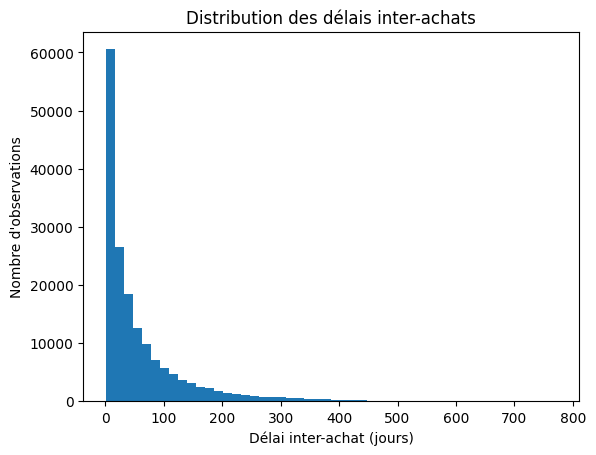

In [21]:
plt.figure()
plt.hist(interpurchase_clean['interpurchase_delay'], bins=50)
plt.xlabel("Délai inter-achat (jours)")
plt.ylabel("Nombre d'observations")
plt.title("Distribution des délais inter-achats")
plt.show()

La distribution des délais inter-achats présente une forte asymétrie à droite (queue droite).
Cela signifie que certains clients ont des délais très longs entre deux achats, ce qui peut correspondre à des comportements saisonniers ou occasionnels.

**Définition du seuil de churn:**

On utilise le 75e percentile.

**4 — Calcul du seuil**

In [22]:
threshold = interpurchase_clean['interpurchase_delay'].quantile(0.75)

print("Seuil proposé (75e percentile) :", threshold)

Seuil proposé (75e percentile) : 77.0


Afin d’identifier les clients présentant un risque élevé de désengagement, nous avons défini le seuil de churn comme le 75e percentile des délais inter-achats.
Cela signifie qu’un client est considéré comme churné s’il est inactif depuis plus longtemps que 75% des cycles d’achat observés.
Le seuil retenu est de X jours.

**Labellisation des clients**

**5-Calcul de la récence actuelle:**

On calcule le nombre de jours depuis le dernier achat.

In [25]:
# Date d'observation (dernière date du dataset)
snapshot_date = transactions['invoice_date'].max()

# Calcul de la dernière date d'achat par client
last_purchase = transactions.groupby('customer_id')['invoice_date'].max().reset_index()

# Calcul de la récence actuelle
last_purchase['recency'] = (
    snapshot_date - last_purchase['invoice_date']
).dt.days

# Labellisation churn
last_purchase['churn'] = (last_purchase['recency'] > threshold).astype(int)

last_purchase.head()

,customer_id,invoice_date,recency,churn
0,12346.0,2011-01-18 10:17:00,325,1
1,12347.0,2011-12-07 15:52:00,1,0
2,12348.0,2011-09-25 13:13:00,74,0
3,12349.0,2011-11-21 09:51:00,18,0
4,12350.0,2011-02-02 16:01:00,309,1


Nous avons calculé la récence actuelle de chaque client (nombre de jours depuis le dernier achat).
Un client est labellisé comme churné (=1) si sa récence dépasse le seuil défini précédemment.
Sinon, il est considéré comme actif (=0).